In [10]:
"""
Residual Analysis: Validating Linear Regression Assumptions
===========================================================

This explores how to diagnose whether your linear regression model
is valid, and how to fix problems when it isn't.

Domain: Microservices - Ensuring regression model assumptions hold
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import shapiro, jarque_bera, anderson
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style("whitegrid")

# Create output directory if it doesn't exist
output_dir = 'user-data/outputs'
os.makedirs(output_dir, exist_ok=True)


PART 1: RESIDUALS - THE MODEL'S LEFTOVER ERRORS

THE RESIDUALS "CONTRACT":
  residuals should look like:
    • Random noise around 0
    • Normally distributed
    • Constant spread
    • No patterns

  If they look like:
    • Curved pattern → Non-linear relationship (bad)
    • Funnel shape → Heteroscedasticity (bad)
    • Clustered outliers → Influential points (bad)
    • Trends → Autocorrelation (bad)
    • Skewed distribution → Non-normal (bad)


PERFECT MODEL - Residuals Statistics:
  Mean: 0.0000 (should be ~0)
  Std Dev: 8.98
  Min: -19.27
  Max: 22.93
  Skewness: 0.217 (should be ~0)
  Kurtosis: -0.071 (should be ~0)

✓ Saved: 14_residuals_perfect_model.png


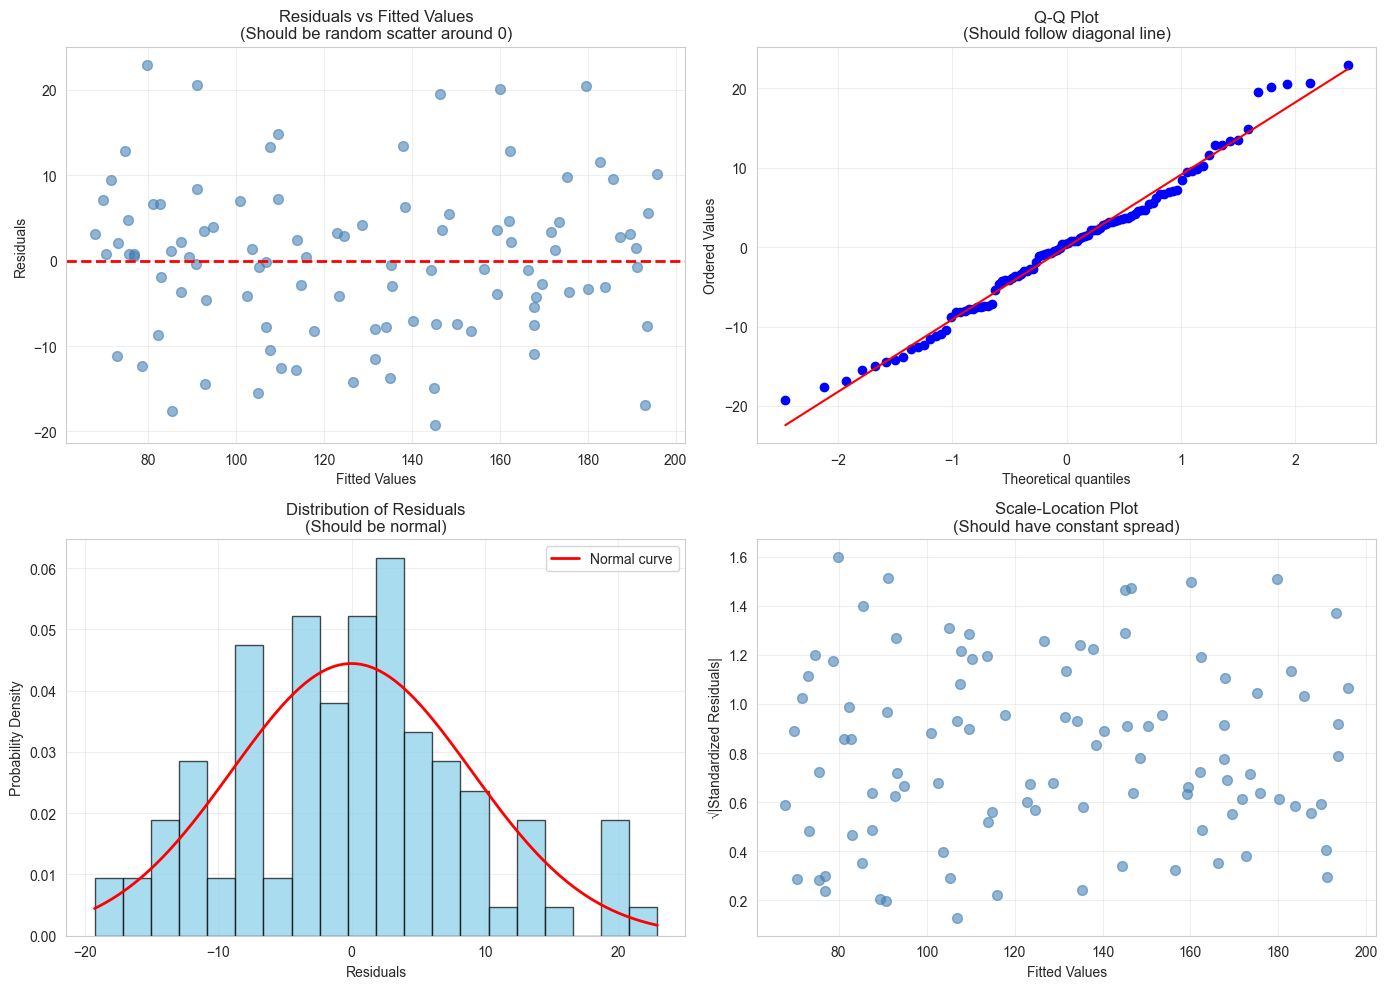

In [11]:
# ============================================================================
# PART 1: WHAT ARE RESIDUALS AND WHY THEY MATTER
# ============================================================================

print("\n" + "="*70)
print("PART 1: RESIDUALS - THE MODEL'S LEFTOVER ERRORS")
print("="*70)

"""
RESIDUALS: The difference between observed and predicted values

residual_i = y_actual_i - y_predicted_i

Why they matter:
  - Residuals tell you HOW WRONG your model is
  - Pattern in residuals = Model assumptions violated
  - Random scatter around 0 = Model assumptions okay ✓
  
LINEAR REGRESSION ASSUMES:
  1. Linearity: Relationship between X and y is linear
  2. Normality: Residuals ~ N(0, σ²)  [normal distribution]
  3. Homoscedasticity: Constant variance (no funnel shape)
  4. Independence: Observations don't influence each other
  5. No outliers/influential points: Extreme values don't dominate

If ANY of these fail → Your model is unreliable!
"""

print("""
THE RESIDUALS "CONTRACT":
  residuals should look like:
    • Random noise around 0
    • Normally distributed
    • Constant spread
    • No patterns
    
  If they look like:
    • Curved pattern → Non-linear relationship (bad)
    • Funnel shape → Heteroscedasticity (bad)
    • Clustered outliers → Influential points (bad)
    • Trends → Autocorrelation (bad)
    • Skewed distribution → Non-normal (bad)
""")

# Create perfect model (assumptions all met)
np.random.seed(42)
X_perfect = np.random.uniform(10, 100, 100)
y_perfect = 50 + 1.5*X_perfect + np.random.normal(0, 10, 100)

model_perfect = LinearRegression()
model_perfect.fit(X_perfect.reshape(-1, 1), y_perfect)
residuals_perfect = y_perfect - model_perfect.predict(X_perfect.reshape(-1, 1))

print(f"\nPERFECT MODEL - Residuals Statistics:")
print(f"  Mean: {residuals_perfect.mean():.4f} (should be ~0)")
print(f"  Std Dev: {residuals_perfect.std():.2f}")
print(f"  Min: {residuals_perfect.min():.2f}")
print(f"  Max: {residuals_perfect.max():.2f}")
print(f"  Skewness: {stats.skew(residuals_perfect):.3f} (should be ~0)")
print(f"  Kurtosis: {stats.kurtosis(residuals_perfect):.3f} (should be ~0)")

# Visualize perfect residuals
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs fitted
ax = axes[0, 0]
y_pred = model_perfect.predict(X_perfect.reshape(-1, 1))
ax.scatter(y_pred, residuals_perfect, alpha=0.6, s=50, color='steelblue')
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Fitted Values\n(Should be random scatter around 0)')
ax.grid(True, alpha=0.3)

# 2. Q-Q plot
ax = axes[0, 1]
stats.probplot(residuals_perfect, dist="norm", plot=ax)
ax.set_title('Q-Q Plot\n(Should follow diagonal line)')
ax.grid(True, alpha=0.3)

# 3. Histogram of residuals
ax = axes[1, 0]
ax.hist(residuals_perfect, bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
mu, sigma = residuals_perfect.mean(), residuals_perfect.std()
x = np.linspace(residuals_perfect.min(), residuals_perfect.max(), 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal curve')
ax.set_xlabel('Residuals')
ax.set_ylabel('Probability Density')
ax.set_title('Distribution of Residuals\n(Should be normal)')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Scale-location plot (homoscedasticity check)
ax = axes[1, 1]
standardized_residuals = residuals_perfect / residuals_perfect.std()
ax.scatter(y_pred, np.sqrt(np.abs(standardized_residuals)), alpha=0.6, s=50, color='steelblue')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('√|Standardized Residuals|')
ax.set_title('Scale-Location Plot\n(Should have constant spread)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '14_residuals_perfect_model.png'), dpi=100)
print("\n✓ Saved: 14_residuals_perfect_model.png")


PART 2: CHECKING LINEARITY ASSUMPTION

Example: Non-linear relationship

NON-LINEAR MODEL - Residuals Pattern:
  Mean: -0.0000
  Std Dev: 18.91
  Pattern: Should see U-shape in residual plot ✗

✓ Saved: 15_linearity_assumption.png


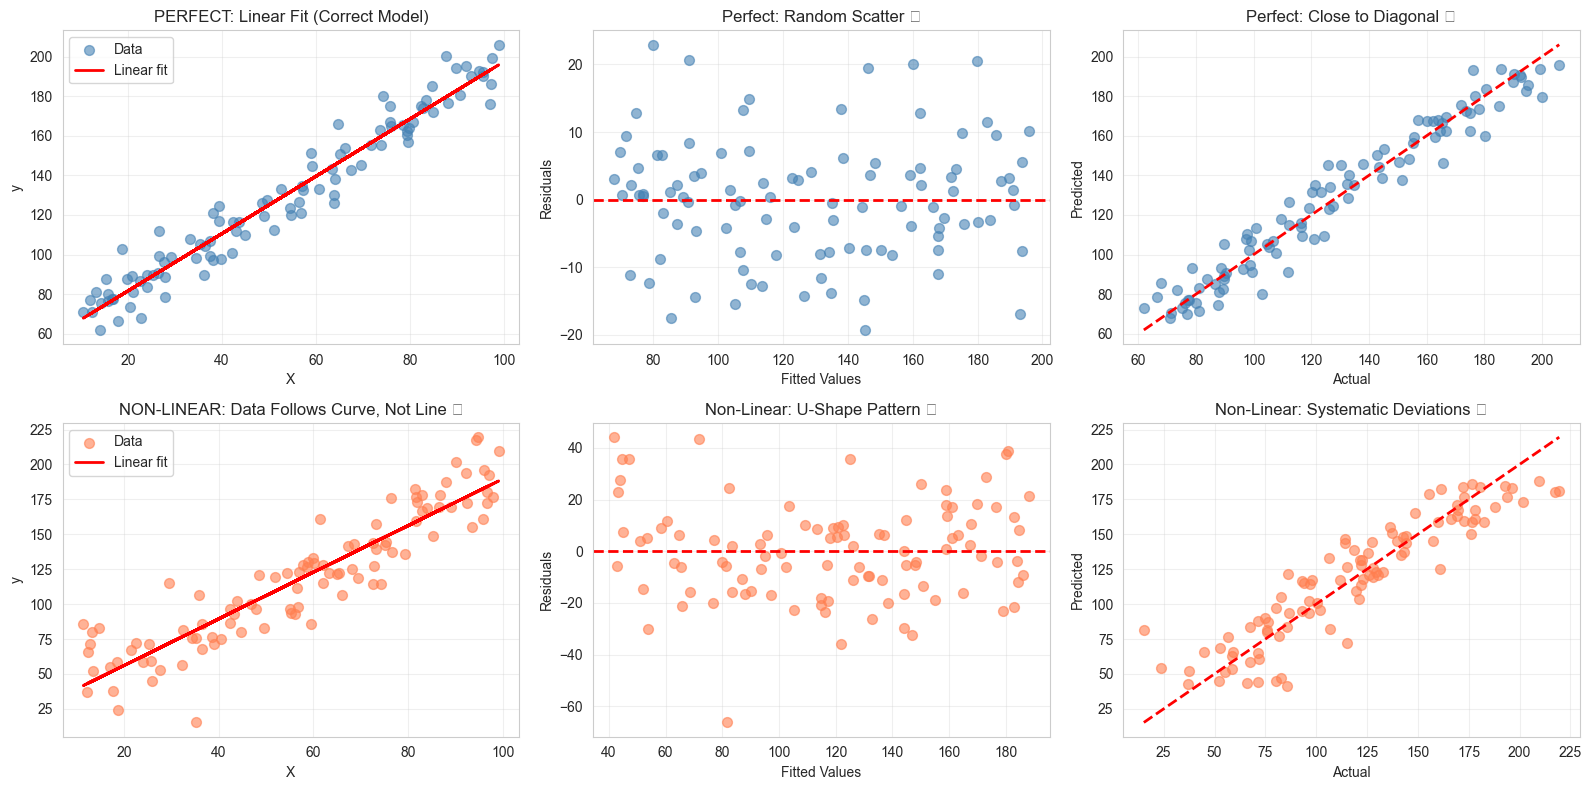

In [12]:
# ============================================================================
# PART 2: LINEARITY ASSUMPTION - IS THE RELATIONSHIP LINEAR?
# ============================================================================

print("\n" + "="*70)
print("PART 2: CHECKING LINEARITY ASSUMPTION")
print("="*70)

"""
LINEARITY ASSUMPTION: The relationship between X and y is linear

VIOLATION: If true relationship is curved/exponential, but you fit a line:
  - You'll see systematic patterns in residuals
  - Residuals will be negative, then positive, then negative again
  - The curve pattern is the smoking gun!
  
DETECTION:
  1. Residuals vs Fitted plot: Look for U-shape or curves
  2. Actual vs Predicted plot: See how far you miss
  3. Partial dependence plots: Isolate each variable
"""

print("\nExample: Non-linear relationship")

# Create NON-LINEAR data (quadratic)
X_nonlinear = np.random.uniform(10, 100, 100)
# True model: y = 50 + 0.5*x + 0.01*x² (quadratic, not linear!)
y_nonlinear = 50 + 0.5*X_nonlinear + 0.01*X_nonlinear**2 + np.random.normal(0, 20, 100)

model_nonlinear = LinearRegression()
model_nonlinear.fit(X_nonlinear.reshape(-1, 1), y_nonlinear)
residuals_nonlinear = y_nonlinear - model_nonlinear.predict(X_nonlinear.reshape(-1, 1))

print(f"\nNON-LINEAR MODEL - Residuals Pattern:")
print(f"  Mean: {residuals_nonlinear.mean():.4f}")
print(f"  Std Dev: {residuals_nonlinear.std():.2f}")
print(f"  Pattern: Should see U-shape in residual plot ✗")

# Compare: perfect vs non-linear
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

y_pred_perf = model_perfect.predict(X_perfect.reshape(-1, 1))
y_pred_nonlin = model_nonlinear.predict(X_nonlinear.reshape(-1, 1))

# Row 1: Perfect model
ax = axes[0, 0]
ax.scatter(X_perfect, y_perfect, alpha=0.6, s=50, label='Data', color='steelblue')
ax.plot(X_perfect, y_pred_perf, 'r-', linewidth=2, label='Linear fit')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('PERFECT: Linear Fit (Correct Model)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.scatter(y_pred_perf, residuals_perfect, alpha=0.6, s=50, color='steelblue')
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Perfect: Random Scatter ✓')
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
ax.scatter(y_perfect, y_pred_perf, alpha=0.6, s=50, color='steelblue')
ax.plot([y_perfect.min(), y_perfect.max()], [y_perfect.min(), y_perfect.max()], 'r--', linewidth=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Perfect: Close to Diagonal ✓')
ax.grid(True, alpha=0.3)

# Row 2: Non-linear model
ax = axes[1, 0]
ax.scatter(X_nonlinear, y_nonlinear, alpha=0.6, s=50, label='Data', color='coral')
ax.plot(X_nonlinear, y_pred_nonlin, 'r-', linewidth=2, label='Linear fit')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('NON-LINEAR: Data Follows Curve, Not Line ✗')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.scatter(y_pred_nonlin, residuals_nonlinear, alpha=0.6, s=50, color='coral')
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Non-Linear: U-Shape Pattern ✗')
ax.grid(True, alpha=0.3)

# Draw U-shape annotation
from matplotlib.patches import Rectangle
# Hint: negative residuals on left, positive in middle, negative on right

ax = axes[1, 2]
ax.scatter(y_nonlinear, y_pred_nonlin, alpha=0.6, s=50, color='coral')
ax.plot([y_nonlinear.min(), y_nonlinear.max()], [y_nonlinear.min(), y_nonlinear.max()], 'r--', linewidth=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Non-Linear: Systematic Deviations ✗')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '15_linearity_assumption.png'), dpi=100)

print("\n✓ Saved: 15_linearity_assumption.png")


PART 3: HOMOSCEDASTICITY - IS VARIANCE CONSTANT?

Example: Heteroscedasticity (funnel shape)

HETEROSCEDASTIC MODEL:
  Residuals std at low X: ~7.00
  Residuals std at high X: ~15.79
  Breusch-Pagan test p-value: 0.0333
  → HETEROSCEDASTICITY DETECTED ✗

✓ Saved: 16_homoscedasticity.png


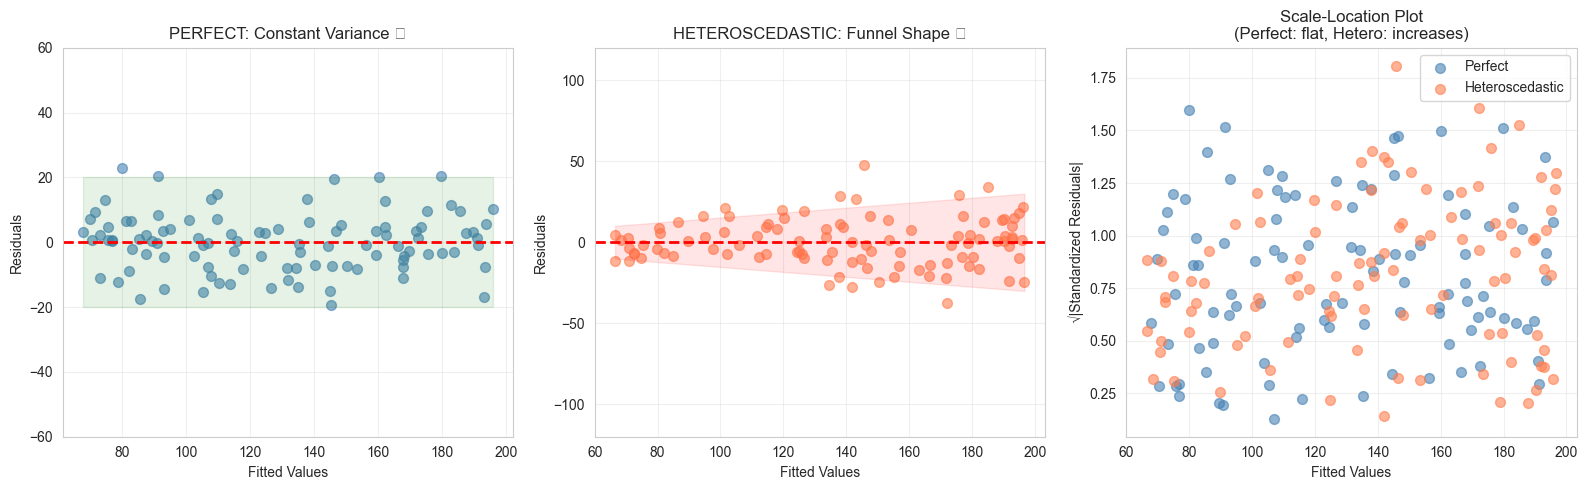

In [13]:
# ============================================================================
# PART 3: HOMOSCEDASTICITY - CONSTANT VARIANCE
# ============================================================================

print("\n" + "="*70)
print("PART 3: HOMOSCEDASTICITY - IS VARIANCE CONSTANT?")
print("="*70)

"""
HOMOSCEDASTICITY: Residuals have constant variance across all fitted values

VIOLATION (Heteroscedasticity):
  - Variance INCREASES with fitted value (funnel shape)
  - Variance DECREASES with fitted value (inverse funnel)
  - Some groups more variable than others
  
CONSEQUENCES:
  - Standard errors are wrong
  - Confidence intervals too narrow or too wide
  - t-tests unreliable
  - Predictions have wrong uncertainty bands
  
DETECTION:
  1. Residuals vs Fitted plot: Look for funnel shape
  2. Scale-Location plot: Spread should be constant
  3. Breusch-Pagan test: Statistical test for heteroscedasticity
"""

print("\nExample: Heteroscedasticity (funnel shape)")

# Create HETEROSCEDASTIC data (variance increases with X)
X_hetero = np.random.uniform(10, 100, 100)
# Variance increases with X
residual_std = 5 + 0.15*X_hetero  # Std dev grows with X!
y_hetero = 50 + 1.5*X_hetero + np.random.normal(0, residual_std)

model_hetero = LinearRegression()
model_hetero.fit(X_hetero.reshape(-1, 1), y_hetero)
residuals_hetero = y_hetero - model_hetero.predict(X_hetero.reshape(-1, 1))

# Breusch-Pagan test
X_design_hetero = np.column_stack([np.ones(len(X_hetero)), X_hetero])
bp_result = het_breuschpagan(residuals_hetero, X_design_hetero)
bp_statistic = bp_result[0]
bp_pvalue = bp_result[1]

print(f"\nHETEROSCEDASTIC MODEL:")
print(f"  Residuals std at low X: ~{residuals_hetero[X_hetero < 30].std():.2f}")
print(f"  Residuals std at high X: ~{residuals_hetero[X_hetero > 80].std():.2f}")
print(f"  Breusch-Pagan test p-value: {bp_pvalue:.4f}")
if bp_pvalue < 0.05:
    print(f"  → HETEROSCEDASTICITY DETECTED ✗")
else:
    print(f"  → Constant variance OK ✓")

# Compare three scenarios
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Perfect (homoscedastic)
ax = axes[0]
y_pred_perf = model_perfect.predict(X_perfect.reshape(-1, 1))
ax.scatter(y_pred_perf, residuals_perfect, alpha=0.6, s=50, color='steelblue')
ax.axhline(0, color='red', linestyle='--', linewidth=2)
# Add spread bands
ax.fill_between(sorted(y_pred_perf), -20, 20, alpha=0.1, color='green')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('PERFECT: Constant Variance ✓')
ax.set_ylim(-60, 60)
ax.grid(True, alpha=0.3)

# 2. Increasing variance (funnel shape)
ax = axes[1]
y_pred_hetero = model_hetero.predict(X_hetero.reshape(-1, 1))
ax.scatter(y_pred_hetero, residuals_hetero, alpha=0.6, s=50, color='coral')
ax.axhline(0, color='red', linestyle='--', linewidth=2)
# Draw funnel
x_band = sorted(y_pred_hetero)
upper_band = 30 * (x_band / y_pred_hetero.max())  # Increasing
lower_band = -upper_band
ax.fill_between(x_band, lower_band, upper_band, alpha=0.1, color='red')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('HETEROSCEDASTIC: Funnel Shape ✗')
ax.set_ylim(-120, 120)
ax.grid(True, alpha=0.3)

# 3. Scale-Location plot comparison
ax = axes[2]
std_resid_perfect = residuals_perfect / residuals_perfect.std()
std_resid_hetero = residuals_hetero / residuals_hetero.std()

ax.scatter(y_pred_perf, np.sqrt(np.abs(std_resid_perfect)), alpha=0.6, s=50, 
          color='steelblue', label='Perfect')
ax.scatter(y_pred_hetero, np.sqrt(np.abs(std_resid_hetero)), alpha=0.6, s=50, 
          color='coral', label='Heteroscedastic')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('√|Standardized Residuals|')
ax.set_title('Scale-Location Plot\n(Perfect: flat, Hetero: increases)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '16_homoscedasticity.png'), dpi=100)

print("\n✓ Saved: 16_homoscedasticity.png")

In [14]:
# ============================================================================
# PART 4: NORMALITY ASSUMPTION (WE'VE SEEN THIS!)
# ============================================================================

print("\n" + "="*70)
print("PART 4: NORMALITY ASSUMPTION REVISITED")
print("="*70)

"""
RECAP: Residuals should be normally distributed

We covered this in Part 2 of the learning path!
  - Q-Q plots: Check visually
  - Shapiro-Wilk test: Statistical test
  - Histogram: Visual inspection

But now in context of FULL MODEL DIAGNOSTICS
"""

# Test normality on different residual distributions
shapiro_perfect = shapiro(residuals_perfect)[1]
shapiro_hetero = shapiro(residuals_hetero)[1]

print(f"\nNormality Tests:")
print(f"  Perfect model Shapiro-Wilk p-value: {shapiro_perfect:.4f} {'✓' if shapiro_perfect > 0.05 else '✗'}")
print(f"  Heteroscedastic model Shapiro-Wilk p-value: {shapiro_hetero:.4f} {'✓' if shapiro_hetero > 0.05 else '✗'}")


PART 4: NORMALITY ASSUMPTION REVISITED

Normality Tests:
  Perfect model Shapiro-Wilk p-value: 0.2984 ✓
  Heteroscedastic model Shapiro-Wilk p-value: 0.7768 ✓



PART 5: OUTLIERS & INFLUENTIAL POINTS

Detecting Outliers and Influential Points

Outlier Detection:
  Point 100: Residual=168.9, Leverage=0.029, Cook's D=0.745
  Point 101: Residual=-133.4, Leverage=0.034, Cook's D=0.560

✓ Saved: 17_outliers_influential_points.png


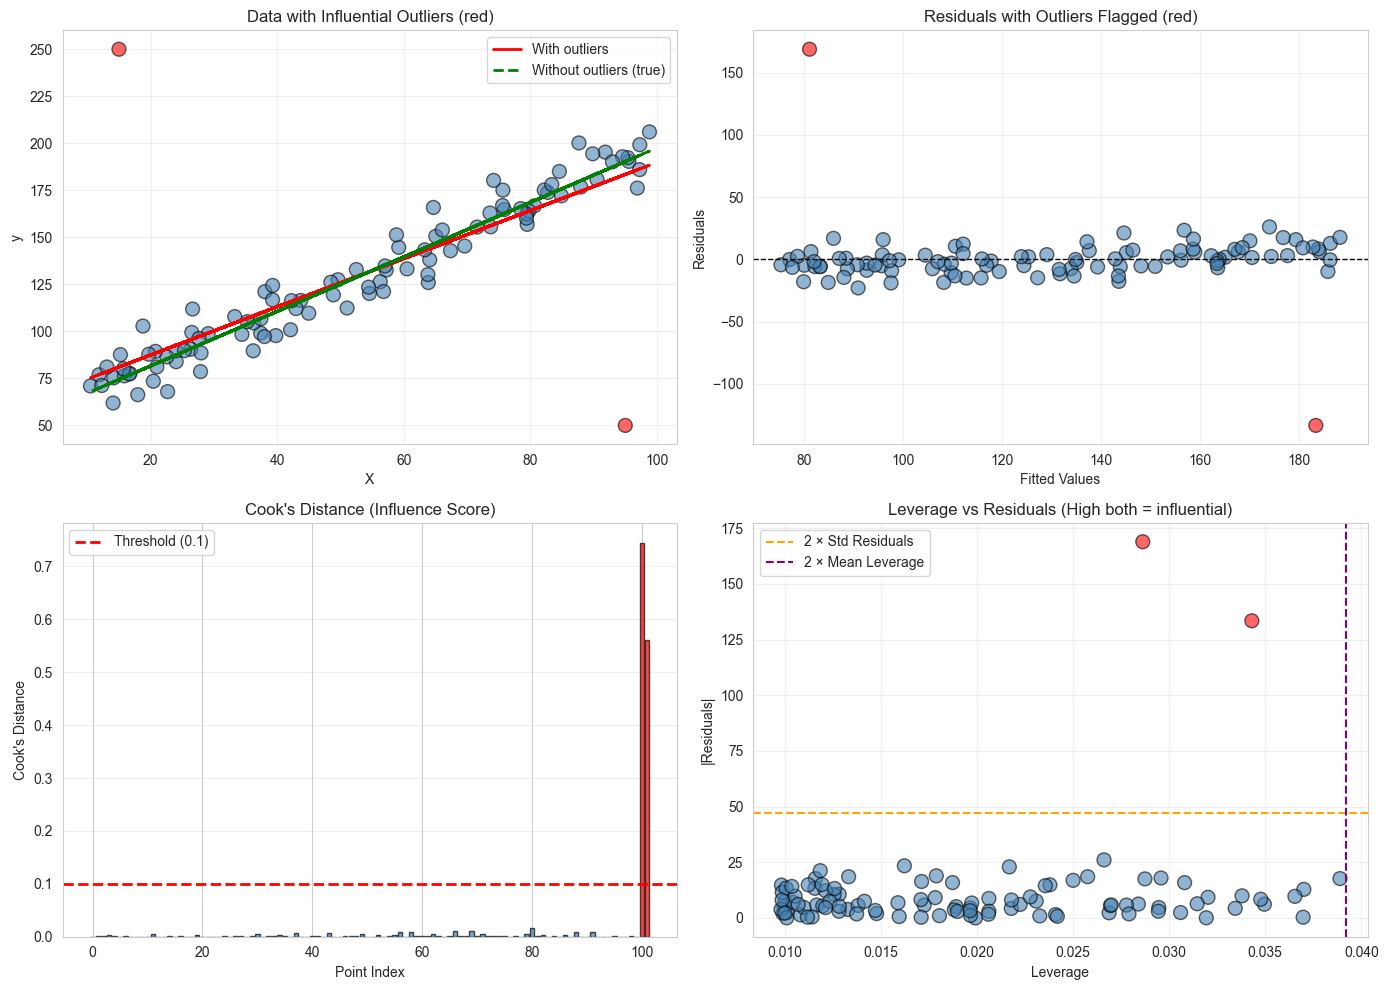

In [15]:
# ============================================================================
# PART 5: OUTLIERS & INFLUENTIAL POINTS - DETECTING LEVERAGE
# ============================================================================

print("\n" + "="*70)
print("PART 5: OUTLIERS & INFLUENTIAL POINTS")
print("="*70)

"""
OUTLIERS: Points with large residuals (far from regression line)

INFLUENTIAL POINTS: Points that have huge effect on the regression line
  - Can have small residuals but large leverage
  - Removing them would drastically change coefficients
  
DETECTION TOOLS:
  1. RESIDUALS: Large residuals = outliers
  2. LEVERAGE: Points far from X-mean have high leverage
     → High leverage point close to line = not influential
     → High leverage point far from line = very influential!
  3. COOK'S DISTANCE: Combined measure of leverage + residual
     → Measures how much removing a point changes the model
     → Cook's D > 0.5 or 1 is concerning
  4. STUDENTIZED RESIDUALS: |t| > 3 is suspicious
"""

print("\nDetecting Outliers and Influential Points")

# Create data with outliers
X_outliers = np.append(X_perfect, [15, 95])  # Add 2 outliers
y_outliers_corrupted = np.append(y_perfect, [250, 50])  # Add extreme y values

model_with_outliers = LinearRegression()
model_with_outliers.fit(X_outliers.reshape(-1, 1), y_outliers_corrupted)
residuals_with_outliers = y_outliers_corrupted - model_with_outliers.predict(X_outliers.reshape(-1, 1))

# Calculate leverage (hat values)
from numpy.linalg import inv
X_design = np.column_stack([np.ones(len(X_outliers)), X_outliers])
hat_matrix = X_design @ inv(X_design.T @ X_design) @ X_design.T
leverage = np.diag(hat_matrix)

# Calculate Cook's distance
mse = np.sum(residuals_with_outliers**2) / (len(y_outliers_corrupted) - 2)
cooks_d = (residuals_with_outliers**2 / 2) * (leverage / (1 - leverage)) / mse

print(f"\nOutlier Detection:")
for i, (res, lev, cd) in enumerate(zip(residuals_with_outliers, leverage, cooks_d)):
    if abs(res) > 50 or cd > 0.1:
        print(f"  Point {i}: Residual={res:.1f}, Leverage={lev:.3f}, Cook's D={cd:.3f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter with outliers
ax = axes[0, 0]
colors = ['red' if cd > 0.1 else 'steelblue' for cd in cooks_d]
ax.scatter(X_outliers, y_outliers_corrupted, c=colors, s=100, alpha=0.6, edgecolors='black')
y_pred_out = model_with_outliers.predict(X_outliers.reshape(-1, 1))
ax.plot(X_outliers, y_pred_out, 'r-', linewidth=2, label='With outliers')
ax.plot(X_perfect, y_pred_perf, 'g--', linewidth=2, label='Without outliers (true)')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Data with Influential Outliers (red)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Residuals with outliers flagged
ax = axes[0, 1]
y_pred_out = model_with_outliers.predict(X_outliers.reshape(-1, 1))
colors = ['red' if cd > 0.1 else 'steelblue' for cd in cooks_d]
ax.scatter(y_pred_out, residuals_with_outliers, c=colors, s=100, alpha=0.6, edgecolors='black')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals with Outliers Flagged (red)')
ax.grid(True, alpha=0.3)

# 3. Cook's distance
ax = axes[1, 0]
colors = ['red' if cd > 0.1 else 'steelblue' for cd in cooks_d]
ax.bar(range(len(cooks_d)), cooks_d, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0.1, color='red', linestyle='--', linewidth=2, label='Threshold (0.1)')
ax.set_xlabel('Point Index')
ax.set_ylabel("Cook's Distance")
ax.set_title("Cook's Distance (Influence Score)")
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 4. Leverage vs Residuals
ax = axes[1, 1]
colors = ['red' if cd > 0.1 else 'steelblue' for cd in cooks_d]
ax.scatter(leverage, np.abs(residuals_with_outliers), c=colors, s=100, alpha=0.6, edgecolors='black')
ax.axhline(2*residuals_with_outliers.std(), color='orange', linestyle='--', label='2 × Std Residuals')
ax.axvline(2*leverage.mean(), color='purple', linestyle='--', label='2 × Mean Leverage')
ax.set_xlabel('Leverage')
ax.set_ylabel('|Residuals|')
ax.set_title('Leverage vs Residuals (High both = influential)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '17_outliers_influential_points.png'), dpi=100)

print("\n✓ Saved: 17_outliers_influential_points.png")


PART 6: INDEPENDENCE ASSUMPTION - NO AUTOCORRELATION

Example: Time Series Data with Autocorrelation

Autocorrelation Detection:
  Durbin-Watson statistic: 0.846
  → POSITIVE AUTOCORRELATION DETECTED ✗

✓ Saved: 18_autocorrelation.png


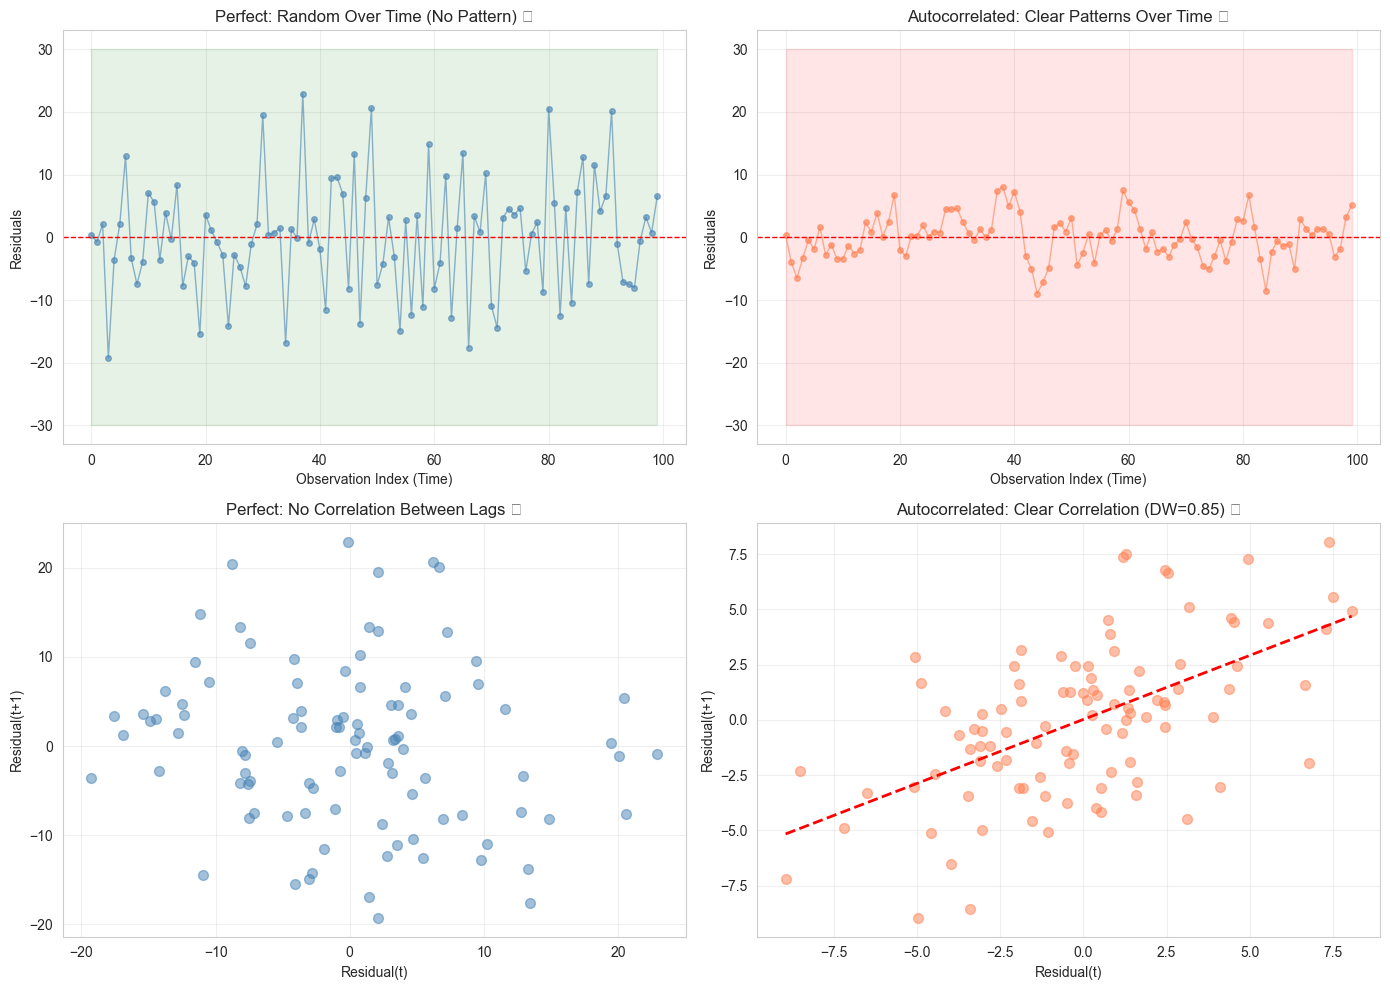

In [16]:
# ============================================================================
# PART 6: INDEPENDENCE - AUTOCORRELATION
# ============================================================================

print("\n" + "="*70)
print("PART 6: INDEPENDENCE ASSUMPTION - NO AUTOCORRELATION")
print("="*70)

"""
INDEPENDENCE: Observations are independent (not related to each other)

VIOLATION (Autocorrelation):
  - Time series data: Sequential observations correlated
  - Example: Server response times: if one is high, next tends high too
  - Residuals cluster in positive/negative blocks
  
CONSEQUENCES:
  - Standard errors TOO SMALL (false confidence!)
  - Confidence intervals too narrow
  - p-values too small (false significance!)
  
DETECTION:
  1. Plot residuals over time: Look for patterns/trends
  2. Durbin-Watson test: Values near 2 = no autocorrelation
     DW ~ 0: Positive autocorrelation
     DW ~ 2: No autocorrelation ✓
     DW ~ 4: Negative autocorrelation
  3. ACF (Autocorrelation Function) plot
"""

print("\nExample: Time Series Data with Autocorrelation")

# Create autocorrelated residuals (time series effect)
n = 100
time_index = np.arange(n)
# Autoregressive process: each residual depends on previous
autocorr_noise = np.zeros(n)
autocorr_noise[0] = np.random.normal(0, 5)
for i in range(1, n):
    autocorr_noise[i] = 0.7*autocorr_noise[i-1] + np.random.normal(0, 3)  # AR(1) process

X_timeseries = np.arange(n)
y_timeseries = 50 + 0.5*X_timeseries + autocorr_noise

model_timeseries = LinearRegression()
model_timeseries.fit(X_timeseries.reshape(-1, 1), y_timeseries)
residuals_ts = y_timeseries - model_timeseries.predict(X_timeseries.reshape(-1, 1))

# Durbin-Watson statistic
dw = np.sum(np.diff(residuals_ts)**2) / np.sum(residuals_ts**2)

print(f"\nAutocorrelation Detection:")
print(f"  Durbin-Watson statistic: {dw:.3f}")
if dw < 1.5:
    print(f"  → POSITIVE AUTOCORRELATION DETECTED ✗")
elif dw > 2.5:
    print(f"  → NEGATIVE AUTOCORRELATION DETECTED ✗")
else:
    print(f"  → No significant autocorrelation ✓")

# Autocorrelation function
from scipy.stats import linregress
acf_values = []
for lag in range(1, 21):
    if lag < len(residuals_ts):
        corr = np.corrcoef(residuals_ts[:-lag], residuals_ts[lag:])[0, 1]
        acf_values.append(corr)

# Compare perfect vs autocorrelated
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals over time (perfect)
ax = axes[0, 0]
ax.plot(residuals_perfect, 'o-', linewidth=1, markersize=4, color='steelblue', alpha=0.6)
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.fill_between(range(len(residuals_perfect)), -30, 30, alpha=0.1, color='green')
ax.set_xlabel('Observation Index (Time)')
ax.set_ylabel('Residuals')
ax.set_title('Perfect: Random Over Time (No Pattern) ✓')
ax.grid(True, alpha=0.3)

# 2. Residuals over time (autocorrelated)
ax = axes[0, 1]
ax.plot(residuals_ts, 'o-', linewidth=1, markersize=4, color='coral', alpha=0.6)
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.fill_between(range(len(residuals_ts)), -30, 30, alpha=0.1, color='red')
ax.set_xlabel('Observation Index (Time)')
ax.set_ylabel('Residuals')
ax.set_title('Autocorrelated: Clear Patterns Over Time ✗')
ax.grid(True, alpha=0.3)

# 3. Lag plot (perfect)
ax = axes[1, 0]
ax.scatter(residuals_perfect[:-1], residuals_perfect[1:], alpha=0.5, s=50, color='steelblue')
ax.set_xlabel('Residual(t)')
ax.set_ylabel('Residual(t+1)')
ax.set_title('Perfect: No Correlation Between Lags ✓')
ax.grid(True, alpha=0.3)

# 4. Lag plot (autocorrelated)
ax = axes[1, 1]
ax.scatter(residuals_ts[:-1], residuals_ts[1:], alpha=0.5, s=50, color='coral')
ax.set_xlabel('Residual(t)')
ax.set_ylabel('Residual(t+1)')
ax.set_title(f'Autocorrelated: Clear Correlation (DW={dw:.2f}) ✗')
# Add trend line
z = np.polyfit(residuals_ts[:-1], residuals_ts[1:], 1)
p = np.poly1d(z)
ax.plot(sorted(residuals_ts[:-1]), p(sorted(residuals_ts[:-1])), "r--", linewidth=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '18_autocorrelation.png'), dpi=100)
print("\n✓ Saved: 18_autocorrelation.png")


PART 7: THE DIAGNOSTIC PLOT - THE GOLD STANDARD

✓ Saved: 19_diagnostic_plots_comparison.png


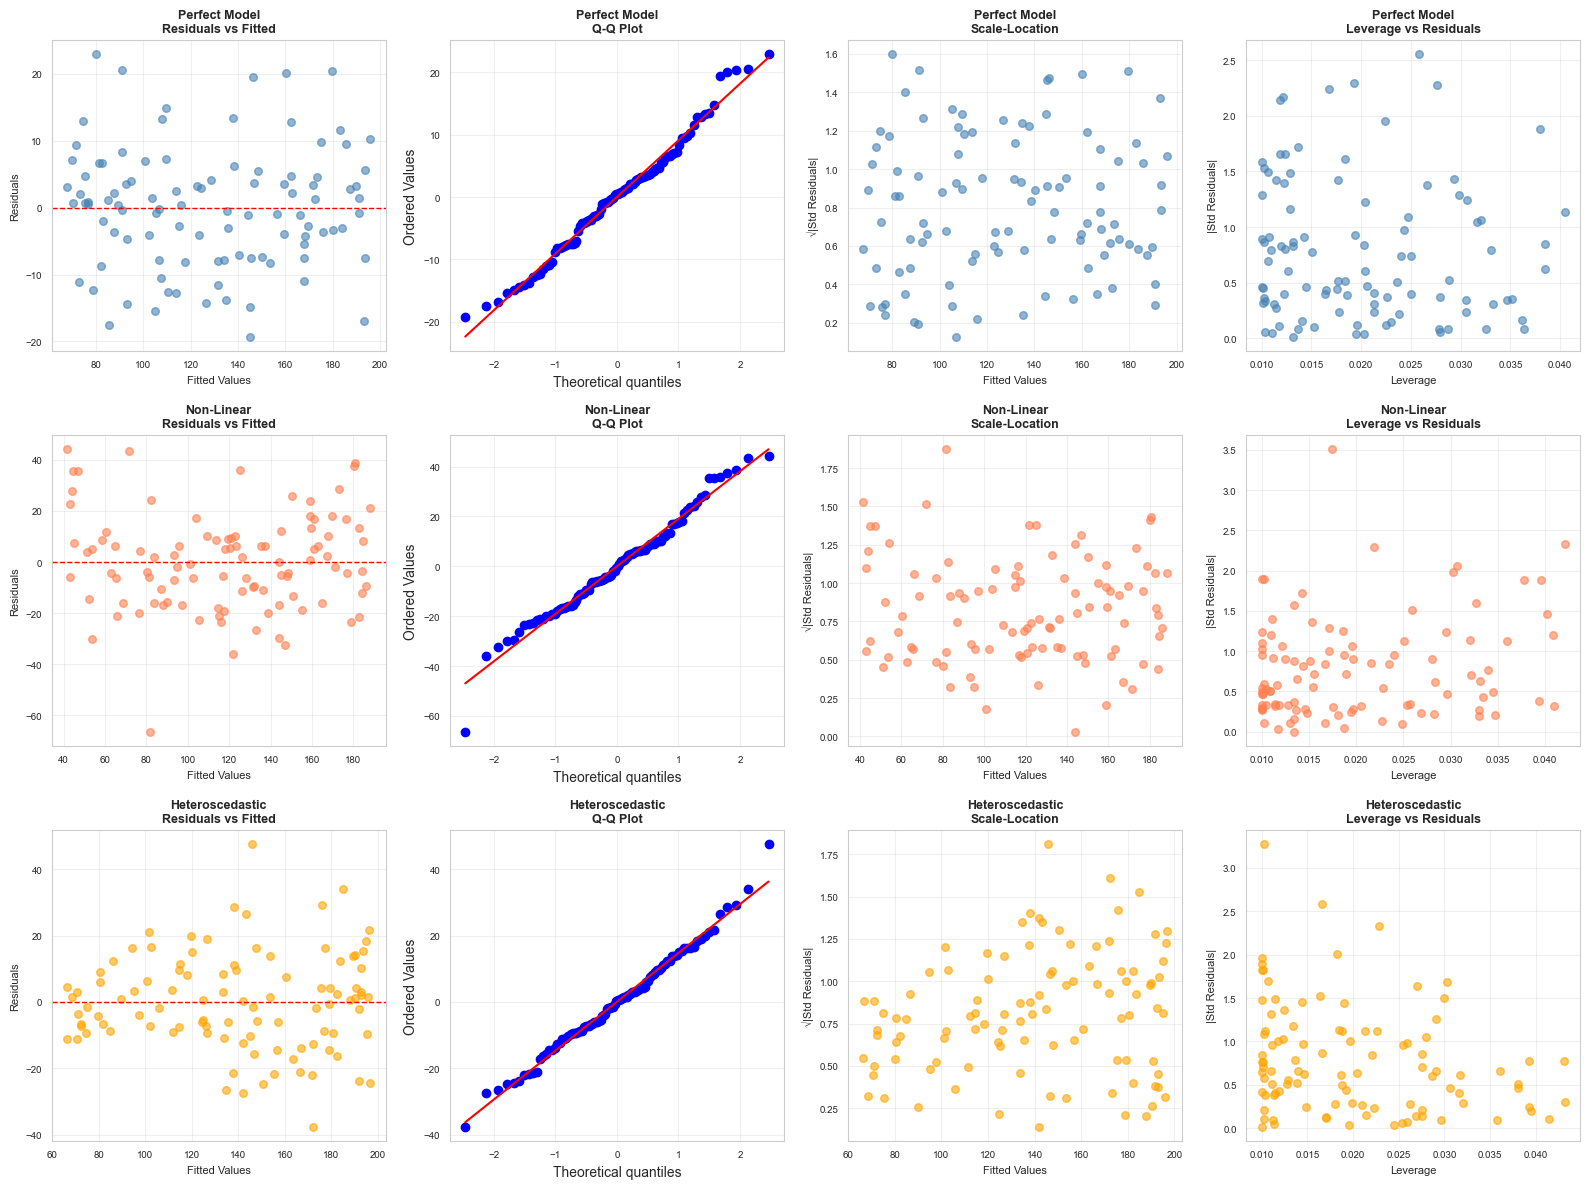

In [17]:
# ============================================================================
# PART 7: THE DIAGNOSTIC PLOT - ALL 4 PLOTS AT ONCE
# ============================================================================

print("\n" + "="*70)
print("PART 7: THE DIAGNOSTIC PLOT - THE GOLD STANDARD")
print("="*70)

"""
THE 4-PLOT DIAGNOSTIC:
  1. Residuals vs Fitted: Linearity + Homoscedasticity
  2. Q-Q Plot: Normality
  3. Scale-Location: Homoscedasticity (alternative view)
  4. Residuals vs Leverage: Influential points

THIS IS THE STANDARD DIAGNOSTIC TOOL IN R AND PYTHON
Every regression analysis should start with these 4 plots!
"""

# Create all diagnostic plots for three models
fig = plt.figure(figsize=(16, 12))

# Define 3 models: perfect, nonlinear, and heteroscedastic
models_to_check = [
    ("Perfect Model", X_perfect, y_perfect, residuals_perfect, 'steelblue'),
    ("Non-Linear", X_nonlinear, y_nonlinear, residuals_nonlinear, 'coral'),
    ("Heteroscedastic", X_hetero, y_hetero, residuals_hetero, 'orange'),
]

for model_idx, (title, X, y, residuals, color) in enumerate(models_to_check):
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X.reshape(-1, 1))
    
    # Calculate diagnostic values
    std_residuals = residuals / residuals.std()
    X_design = np.column_stack([np.ones(len(X)), X])
    hat_matrix = X_design @ inv(X_design.T @ X_design) @ X_design.T
    leverage = np.diag(hat_matrix)
    
    # 1. Residuals vs Fitted
    ax = plt.subplot(3, 4, model_idx*4 + 1)
    ax.scatter(y_pred, residuals, alpha=0.6, s=30, color=color)
    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('Fitted Values', fontsize=8)
    ax.set_ylabel('Residuals', fontsize=8)
    ax.set_title(f'{title}\nResiduals vs Fitted', fontsize=9, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=7)
    
    # 2. Q-Q Plot
    ax = plt.subplot(3, 4, model_idx*4 + 2)
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title(f'{title}\nQ-Q Plot', fontsize=9, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=7)
    
    # 3. Scale-Location
    ax = plt.subplot(3, 4, model_idx*4 + 3)
    ax.scatter(y_pred, np.sqrt(np.abs(std_residuals)), alpha=0.6, s=30, color=color)
    ax.set_xlabel('Fitted Values', fontsize=8)
    ax.set_ylabel('√|Std Residuals|', fontsize=8)
    ax.set_title(f'{title}\nScale-Location', fontsize=9, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=7)
    
    # 4. Residuals vs Leverage
    ax = plt.subplot(3, 4, model_idx*4 + 4)
    ax.scatter(leverage, np.abs(std_residuals), alpha=0.6, s=30, color=color)
    ax.set_xlabel('Leverage', fontsize=8)
    ax.set_ylabel('|Std Residuals|', fontsize=8)
    ax.set_title(f'{title}\nLeverage vs Residuals', fontsize=9, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=7)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '19_diagnostic_plots_comparison.png'), dpi=100, bbox_inches='tight')
print("\n✓ Saved: 19_diagnostic_plots_comparison.png")


PART 8: FIXING PROBLEMS - SOLUTIONS FOR VIOLATIONS

Example: Fixing Non-Linearity with Polynomial

Non-Linearity Fix:
  Linear Model R² = 0.8382
  Polynomial (degree 2) R² = 0.8561
  Improvement: 1.8%

Residual Normality:
  Linear model Shapiro-Wilk p: 0.1623
  Polynomial model Shapiro-Wilk p: 0.5102


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/0_fixing_nonlinearity.png'

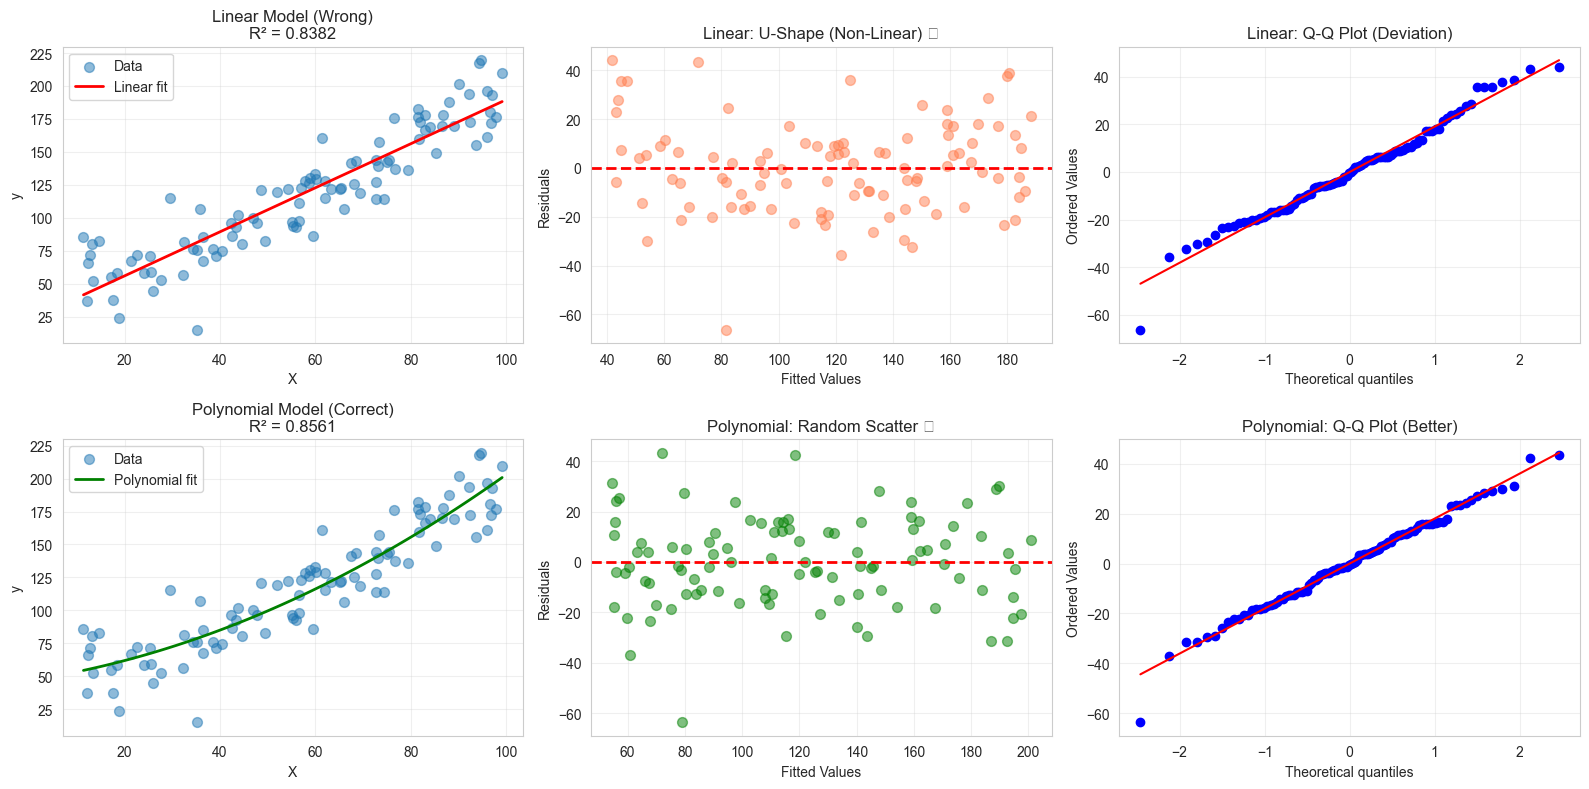

In [ ]:
# ============================================================================
# PART 8: FIXING PROBLEMS - SOLUTIONS
# ============================================================================

print("\n" + "="*70)
print("PART 8: FIXING PROBLEMS - SOLUTIONS FOR VIOLATIONS")
print("="*70)

"""
WHEN YOU DETECT PROBLEMS:

1. NON-LINEARITY (curved residual plot):
   ✓ Add polynomial terms: y ~ x + x²
   ✓ Add interaction terms: y ~ x₁ + x₂ + x₁×x₂
   ✓ Transform variables: log(x), sqrt(x), 1/x
   ✓ Use non-linear model: splines, trees, neural networks

2. HETEROSCEDASTICITY (funnel shape):
   ✓ Transform y: log(y), sqrt(y)
   ✓ Weighted least squares: weight by 1/σᵢ²
   ✓ Use robust standard errors
   ✓ Add missing variables (often fixes this)

3. NON-NORMALITY (skewed Q-Q plot):
   ✓ Transform y: log(y), Box-Cox
   ✓ Robust regression methods
   ✓ Larger sample size (CLT helps)

4. OUTLIERS (extreme Cook's D):
   ✓ Remove if data error
   ✓ Keep but use robust methods
   ✓ Investigate why it's extreme

5. AUTOCORRELATION (patterns over time):
   ✓ Add lagged variables
   ✓ Use time series models (ARIMA, etc.)
   ✓ Difference the data
"""

print("\nExample: Fixing Non-Linearity with Polynomial")

# Original non-linear data
X_nl = X_nonlinear
y_nl = y_nonlinear

# Model 1: Linear (wrong)
model_linear = LinearRegression()
model_linear.fit(X_nl.reshape(-1, 1), y_nl)
r2_linear = model_linear.score(X_nl.reshape(-1, 1), y_nl)
residuals_linear = y_nl - model_linear.predict(X_nl.reshape(-1, 1))

# Model 2: Polynomial (quadratic)
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_nl.reshape(-1, 1))

model_poly = LinearRegression()
model_poly.fit(X_poly, y_nl)
r2_poly = model_poly.score(X_poly, y_nl)
residuals_poly = y_nl - model_poly.predict(X_poly)

print(f"\nNon-Linearity Fix:")
print(f"  Linear Model R² = {r2_linear:.4f}")
print(f"  Polynomial (degree 2) R² = {r2_poly:.4f}")
print(f"  Improvement: {(r2_poly - r2_linear)*100:.1f}%")

# Test normality
shapiro_linear = shapiro(residuals_linear)[1]
shapiro_poly = shapiro(residuals_poly)[1]

print(f"\nResidual Normality:")
print(f"  Linear model Shapiro-Wilk p: {shapiro_linear:.4f}")
print(f"  Polynomial model Shapiro-Wilk p: {shapiro_poly:.4f}")

# Visualize the fix
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Row 1: Linear (wrong) model
ax = axes[0, 0]
ax.scatter(X_nl, y_nl, alpha=0.5, s=50, label='Data')
X_line = np.linspace(X_nl.min(), X_nl.max(), 100)
y_line_linear = model_linear.predict(X_line.reshape(-1, 1))
ax.plot(X_line, y_line_linear, 'r-', linewidth=2, label='Linear fit')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title(f'Linear Model (Wrong)\nR² = {r2_linear:.4f}')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
y_pred_linear = model_linear.predict(X_nl.reshape(-1, 1))
ax.scatter(y_pred_linear, residuals_linear, alpha=0.5, s=50, color='coral')
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Linear: U-Shape (Non-Linear) ✗')
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
stats.probplot(residuals_linear, dist="norm", plot=ax)
ax.set_title('Linear: Q-Q Plot (Deviation)')
ax.grid(True, alpha=0.3)

# Row 2: Polynomial (correct) model
ax = axes[1, 0]
ax.scatter(X_nl, y_nl, alpha=0.5, s=50, label='Data')
X_line_full = np.column_stack([X_line, X_line**2])
y_line_poly = model_poly.predict(X_line_full)
ax.plot(X_line, y_line_poly, 'g-', linewidth=2, label='Polynomial fit')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title(f'Polynomial Model (Correct)\nR² = {r2_poly:.4f}')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
y_pred_poly = model_poly.predict(X_poly)
ax.scatter(y_pred_poly, residuals_poly, alpha=0.5, s=50, color='green')
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Polynomial: Random Scatter ✓')
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
stats.probplot(residuals_poly, dist="norm", plot=ax)
ax.set_title('Polynomial: Q-Q Plot (Better)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '0_fixing_nonlinearity.png'), dpi=100)
print("\n✓ Saved: 0_fixing_nonlinearity.png")

In [ ]:
# ============================================================================
# PART 9: PARETO ESSENTIALS - RESIDUAL ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("PART 9: PARETO ESSENTIALS - THE 20% THAT MATTERS")
print("="*70)

pareto_map = """
┌─ RESIDUAL ANALYSIS: VALIDATING REGRESSION ──────────────────────────┐
│                                                                      │
│  ROOT: Model Validation                                              │
│  └─ "Are my regression assumptions satisfied?"                      │
│                                                                      │
│  ASSUMPTION 1: LINEARITY                                             │
│  ├─ True relationship is linear                                     │
│  ├─ Detection: U-shape or curves in residuals vs fitted plot       │
│  ├─ Fix: Add polynomial terms, transform, or non-linear models     │
│  └─ Impact: Model systematically wrong if violated                 │
│                                                                      │
│  ASSUMPTION 2: NORMALITY                                             │
│  ├─ Residuals ~ N(0, σ²)                                           │
│  ├─ Detection: Q-Q plot deviates, Shapiro-Wilk test sig.          │
│  ├─ Fix: Transform y (log, sqrt, Box-Cox), larger sample           │
│  └─ Impact: Confidence intervals & p-values unreliable             │
│                                                                      │
│  ASSUMPTION 3: HOMOSCEDASTICITY                                      │
│  ├─ Constant variance across all fitted values                     │
│  ├─ Detection: Funnel shape in residuals vs fitted                 │
│  ├─ Fix: Transform y, weighted least squares, add variables        │
│  └─ Impact: Standard errors wrong, CI too narrow/wide              │
│                                                                      │
│  ASSUMPTION 4: INDEPENDENCE                                          │
│  ├─ Observations not related to each other                         │
│  ├─ Detection: Patterns in residuals over time, Durbin-Watson      │
│  ├─ Fix: Add lagged variables, time series models                  │
│  └─ Impact: Standard errors too small (false confidence)           │
│                                                                      │
│  ASSUMPTION 5: NO EXTREME OUTLIERS                                   │
│  ├─ No points that dominate the fit                                │
│  ├─ Detection: Cook's D > 0.5 or 1, high leverage + high residual │
│  ├─ Fix: Remove if error, robust methods, investigate why          │
│  └─ Impact: Coefficients unstable and untrustworthy                │
│                                                                      │
│  THE DIAGNOSTIC PLOTS (4 Essential Plots):                          │
│  ├─ 1. Residuals vs Fitted: Linearity + Homoscedasticity          │
│  ├─ 2. Q-Q Plot: Normality                                         │
│  ├─ 3. Scale-Location: Homoscedasticity (root scale)              │
│  └─ 4. Residuals vs Leverage: Influential points                   │
│                                                                      │
│  THE 20% THAT MATTERS:                                               │
│  ✓ Plot residuals vs fitted → check for patterns                   │
│  ✓ Q-Q plot → check normality                                      │
│  ✓ Look for funnel shape → heteroscedasticity                      │
│  ✓ Cook's D > 0.5 → influential points                             │
│  ✓ Patterns over time → autocorrelation                            │
│  ✓ If violations found → transform, add terms, or use robust methods
│                                                                      │
└──────────────────────────────────────────────────────────────────────┘
"""

print(pareto_map)

In [ ]:
# ============================================================================
# PART 10: PRACTICAL WORKFLOW
# ============================================================================

print("\n" + "="*70)
print("PART 10: YOUR RESIDUAL ANALYSIS WORKFLOW")
print("="*70)

workflow = """
STEP 1: Fit Linear Regression
  from sklearn.linear_model import LinearRegression
  model = LinearRegression()
  model.fit(X, y)
  
STEP 2: Extract Residuals
  residuals = y - model.predict(X)
  y_pred = model.predict(X)

STEP 3: Create Diagnostic Plots
  import matplotlib.pyplot as plt
  from scipy import stats
  
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))
  
  # Plot 1: Residuals vs Fitted
  axes[0,0].scatter(y_pred, residuals)
  axes[0,0].axhline(0, color='r', linestyle='--')
  axes[0,0].set_xlabel('Fitted Values')
  axes[0,0].set_ylabel('Residuals')
  # Look for: Random scatter around 0 ✓
  
  # Plot 2: Q-Q Plot
  stats.probplot(residuals, dist="norm", plot=axes[0,1])
  # Look for: Points on diagonal line ✓
  
  # Plot 3: Scale-Location
  std_residuals = residuals / residuals.std()
  axes[1,0].scatter(y_pred, np.sqrt(np.abs(std_residuals)))
  # Look for: Constant horizontal spread ✓
  
  # Plot 4: Residuals vs Leverage (optional, needs hat matrix)
  # Look for: No points with high leverage AND high residuals ✓

STEP 4: Statistical Tests
  from scipy.stats import shapiro
  from statsmodels.stats.diagnostic import het_breuschpagan
  
  # Normality test
  stat, p_value = shapiro(residuals)
  if p_value > 0.05: print("✓ Residuals are normal")
  
  # Heteroscedasticity test
  bp_stat, bp_p = het_breuschpagan(residuals, y_pred)
  if bp_p > 0.05: print("✓ Constant variance")
  
  # Autocorrelation (time series)
  from scipy.stats import linregress
  dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
  if 1.5 < dw < 2.5: print("✓ No autocorrelation")

STEP 5: Interpret Findings
  
  GOOD DIAGNOSTICS:
    • Random scatter in residuals vs fitted
    • Points on diagonal in Q-Q plot
    • Horizontal line in scale-location
    • No extreme outliers
    → Model assumptions satisfied ✓
  
  BAD DIAGNOSTICS:
    • Curved pattern in residuals vs fitted
      → Add polynomial terms or transform
    • Points deviate from diagonal in Q-Q
      → Non-normal residuals, consider transformation
    • Funnel shape in scale-location
      → Heteroscedasticity, transform y or use WLS
    • Extreme Cook's D values
      → Influential points, investigate or use robust methods

STEP 6: Fix Problems (if needed)
  
  # Non-linearity
  from sklearn.preprocessing import PolynomialFeatures
  poly = PolynomialFeatures(degree=2)
  X_poly = poly.fit_transform(X)
  
  # Heteroscedasticity
  from scipy.stats import boxcox
  y_transformed, lambda_optimal = boxcox(y[y > 0])
  
  # Outliers
  # Option 1: Remove if error
  # Option 2: Use robust regression
  from sklearn.linear_model import HuberRegressor

STEP 7: Recheck Residuals
  # Refit with transformed/fixed data
  # Repeat diagnostic plots
  # Should see improvements
"""

print(workflow)

In [ ]:
# ============================================================================
# PART 11: SUMMARY
# ============================================================================

print("\n" + "="*70)
print("SUMMARY: RESIDUAL ANALYSIS")
print("="*70)

summary = """
YOU NOW UNDERSTAND:

1. ✓ Residuals: Observed - Predicted
2. ✓ Linearity Assumption: Relationship is linear
3. ✓ Normality Assumption: Residuals ~ N(0, σ²)
4. ✓ Homoscedasticity: Constant variance
5. ✓ Independence: No autocorrelation
6. ✓ Outliers/Influential Points: Cook's D, Leverage
7. ✓ The 4 Diagnostic Plots: Your validation toolkit
8. ✓ How to Fix Problems: Transform, add terms, robust methods

KEY DIAGNOSTIC PLOTS:
1. Residuals vs Fitted: Linearity + Homoscedasticity
2. Q-Q Plot: Normality
3. Scale-Location: Homoscedasticity (alternative)
4. Residuals vs Leverage: Influential points

INTERPRETATION GUIDE:

Perfect Model:
  • Residuals vs Fitted: Random scatter around 0
  • Q-Q Plot: Points on diagonal line
  • Scale-Location: Constant horizontal spread
  • No points with high Cook's D

Non-Linear:
  • Residuals vs Fitted: U-shape or S-shape
  • Fix: Add polynomial terms, transform

Heteroscedastic:
  • Scale-Location: Funnel shape
  • Residuals vs Fitted: Spreading increases
  • Fix: Transform y (log, sqrt, Box-Cox)

Non-Normal:
  • Q-Q Plot: Deviates from diagonal
  • Histogram: Skewed distribution
  • Fix: Transform y, larger sample

Autocorrelated:
  • Residuals over time: Clear patterns
  • Lag plot: Positive slope
  • Durbin-Watson: < 1.5 or > 2.5
  • Fix: Add lagged terms, time series model

CONNECTED TO YOUR LEARNING:

• Normal Distribution ← Residuals should follow this
• Correlation/Covariance ← Check for multicollinearity (separate topic)
• Hypothesis Testing ← Shapiro-Wilk, Breusch-Pagan use hypothesis framework
• Linear Regression ← Foundation being validated
• Residual Analysis ← **You are here**

NEXT TOPICS:
→ Cross-Validation: How to validate predictive power
→ Regularization (Ridge/Lasso): Handling multicollinearity
→ Logistic Regression: When y is binary/categorical
→ Time Series Methods: When data has temporal structure
"""

print(summary)

print("\n" + "="*70)
print("All visualizations saved to /mnt/user-data/outputs/")
print("="*70)